In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
np.random.seed(42069)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, learning_curve, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn import metrics
# SKlearn forza los warnings y no es posible desactivarlos aunque seamos concientes de lo que involucren. Asi que uso este 
# codigo para deshacerme de ello y usar penalty l1 sin que nadie me ande diciendo nada.
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from keras.layers import Dense
from keras.utils import np_utils
from keras.models import model_from_json
from keras.utils import plot_model

### Objetivo: A partir de las siguientes variables:
### Edad, sexo, vitamina D, hormona paratiroidea, circunferencia de la cintura, indice de masa corporal, altura, raza (blanco, negro o mexicano), ingreso familiar anual, calcio, fósforo y energía en calorías...

# Hacer un clasificador ¡De estado civil!

### Las diferentes clases a encontrar son: 

1. Casado 
2. Viudo
3. Divorciado
4. Separado 
5. Nunca se ha casado
6. En unión libre (Goals)

In [3]:
df = pd.read_csv('BaseDatosEstudio.csv')
datos = df.loc[:,['ridagemn', 'ridreth1', 'indhhinc', 'indfminc', 'indfmpir', 'lbdvidms', 
        'lbxpt21', 'riagendr', 'dr1tkcal', 'dr1tcalc', 'dr1tphos', 'bmxwt', 'bmxht', 'bmxbmi', 'bmxwaist', 'dmdmartl']]
datos = datos[datos['dmdmartl'] < 7]
datos = datos.dropna()
datos = datos.reset_index()
datos.head()

,index,ridagemn,ridreth1,indhhinc,indfminc,indfmpir,lbdvidms,lbxpt21,riagendr,dr1tkcal,dr1tcalc,dr1tphos,bmxwt,bmxht,bmxbmi,bmxwaist,dmdmartl
0,0,232.0,4,6.0,6.0,2.44,31.2,56.0,1,2984.0,419.0,993.0,137.6,164.5,50.85,135.9,5.0
1,1,203.0,4,7.0,6.0,2.47,45.9,47.0,2,1178.0,405.0,611.0,55.2,163.0,20.78,73.6,5.0
2,3,208.0,4,11.0,7.0,2.75,70.4,37.0,1,2457.0,633.0,1703.0,70.0,184.1,20.65,74.7,5.0
3,4,671.0,3,8.0,8.0,3.79,72.9,35.0,1,5606.0,1480.0,3661.0,103.1,181.6,31.26,118.4,1.0
4,5,633.0,3,6.0,4.0,1.24,40.9,26.0,2,2171.0,961.0,1265.0,67.9,163.2,25.49,91.4,6.0


### Comenzando por una regresión logística. Al ser un problema multiclase, decidí usar One vs Rest.

### Tampoco hay muchos datos después de la limpieza, así que vamos a usar KFolds(10) para reproducir datos de entrenamiento y testeo.

In [4]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure(figsize=(12, 8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt

x = np.array(datos.drop(columns=['dmdmartl'], axis=1))
y = datos['dmdmartl'].values
clf = LogisticRegression(multi_class='ovr', solver='liblinear')
kfold = KFold(n_splits=10, shuffle=True)

<module 'matplotlib.pyplot' from '/home/victor/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

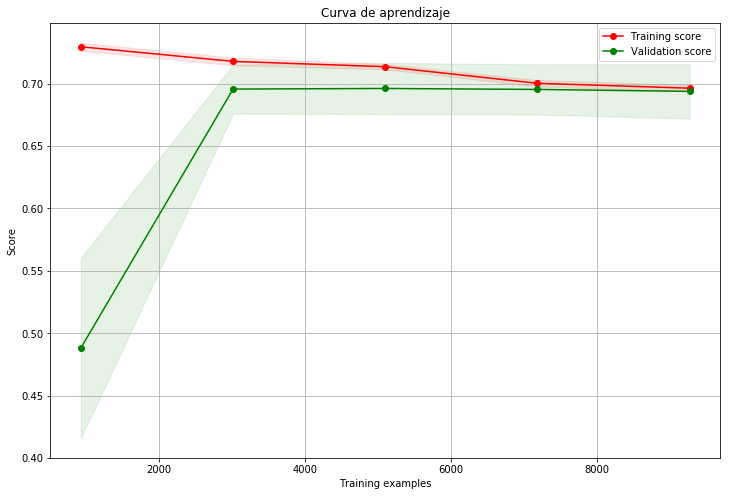

In [37]:
plot_learning_curve(clf, "Curva de aprendizaje", x, y, cv=kfold, n_jobs=4)

### Máquinas de vector de soporte: Solo pude usar kernel lineal. Al parecer utilizar kernels como el gaussiano, polinomial, sigmoidal etc rompía la máquina, porque son muchos datos. De todas maneras, no daban mas del 60% de exactitud

In [12]:
clasificadores = [LinearSVC(dual=False, max_iter=1300), LinearSVC(dual=False, penalty='l1', max_iter=2000),
                  MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 10, 10, 5), random_state=1)]

nombres =['SVM lineal 1', 'SVM lineal 2', 'Perceptron multicapa']    

for nombre, clf in zip(nombres, clasificadores):
    resultados = cross_val_score(clf, x, y, cv=kfold)
    print('Exactitud promedio en 10 folds para {}: {}, con sigma={}'.format(nombre, resultados.mean(), resultados.std()))

Exactitud promedio en 10 folds para SVM lineal 1: 0.6870418012486699, con sigma=0.013627223787235257


/home/victor/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/victor/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/victor/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/victor/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/victor/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

Exactitud promedio en 10 folds para SVM lineal 2: 0.6905319559669658, con sigma=0.00761087364081853
Exactitud promedio en 10 folds para Perceptron multicapa: 0.2527150565479834, con sigma=0.019605283073224337


### El perceptrón multicapa de SKLearn, probado con 5 capas con diferentes números altos de neuronas. Resultados no fueron buenos quizá por el alto número de neuronas.

In [15]:
clasificadores = [MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16, 32, 32, 16), random_state=1), 
                  MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(32, 64, 64, 32), random_state=1),
                 MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8, 16, 16, 16, 8), random_state=1),
                 MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16, 32, 64, 32, 16), random_state=1),
                 MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8, 8, 8, 8), random_state=1),
                 MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8, 8, 8), random_state=1),
                 MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16, 16, 16), random_state=1)]

for clf in clasificadores:
    resultados = cross_val_score(clf, x, y, cv=kfold)
    print('Exactitud promedio en 10 folds: {}, con sigma={}'.format(resultados.mean(), resultados.std()))

Exactitud promedio en 10 folds: 0.41977220720763136, con sigma=0.019949531335352006
Exactitud promedio en 10 folds: 0.39910483741866226, con sigma=0.015114880349288916
Exactitud promedio en 10 folds: 0.5755418907084271, con sigma=0.126099652220908
Exactitud promedio en 10 folds: 0.07314672341868109, con sigma=0.007902814828428117
Exactitud promedio en 10 folds: 0.4269575207405384, con sigma=0.027348156635761206
Exactitud promedio en 10 folds: 0.42200182686241094, con sigma=0.00792312487022534
Exactitud promedio en 10 folds: 0.4182178674677238, con sigma=0.011967357914191453


### Probé también con otros algoritmos de clasificación, como el K vecinos, Naive Bayes y árboles de decisión.

In [13]:
clasificadores = [KNeighborsClassifier(n_neighbors=4), GaussianNB(), ComplementNB(), DecisionTreeClassifier()]

nombres =['K vecinos', 'Naive Bayes', 'Complement NB', 'Arboles de decisión']

for nombre, clf in zip(nombres, clasificadores):
    resultados = cross_val_score(clf, x, y, cv=kfold)
    print('Exactitud promedio en 10 folds para {}: {}, con sigma={}'.format(nombre, resultados.mean(), resultados.std()))

Exactitud promedio en 10 folds para K vecinos: 0.5761526654299247, con sigma=0.0125230086630583
Exactitud promedio en 10 folds para Naive Bayes: 0.6287378640776699, con sigma=0.01053833046593847
Exactitud promedio en 10 folds para Complement NB: 0.5367642876649119, con sigma=0.017002598959618295
Exactitud promedio en 10 folds para Arboles de decisión: 0.6305787575452243, con sigma=0.010103069992568225


### Y nuevamente probé con el percentron multicapa sin mucho éxito.

In [16]:
clasificadores = [MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(8, 16, 16, 8), random_state=1), 
                 MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(16, 32, 64, 32, 16), random_state=1),
                 MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(16, 32, 32, 16), random_state=1)]
for clf in clasificadores:
    resultados = cross_val_score(clf, x, y, cv=kfold)
    print('Exactitud promedio en 10 folds: {}, con sigma={}'.format(resultados.mean(), resultados.std()))

Exactitud promedio en 10 folds: 0.4234564425150434, con sigma=0.016203258482612278
Exactitud promedio en 10 folds: 0.4197709830214798, con sigma=0.014740401362718042
Exactitud promedio en 10 folds: 0.4197699471716591, con sigma=0.012069540893146803


## Posibilidades a contemplar: 
## 1. Diseñar una red neuronal en tensorflow/keras 
## 2. Extraer posibles variables de confusión
## 3. Graficar los datos (perdón por dejar esto hasta el final, Anscombe).

### Por respeto a Anscombe, decidí empezar por el plot.

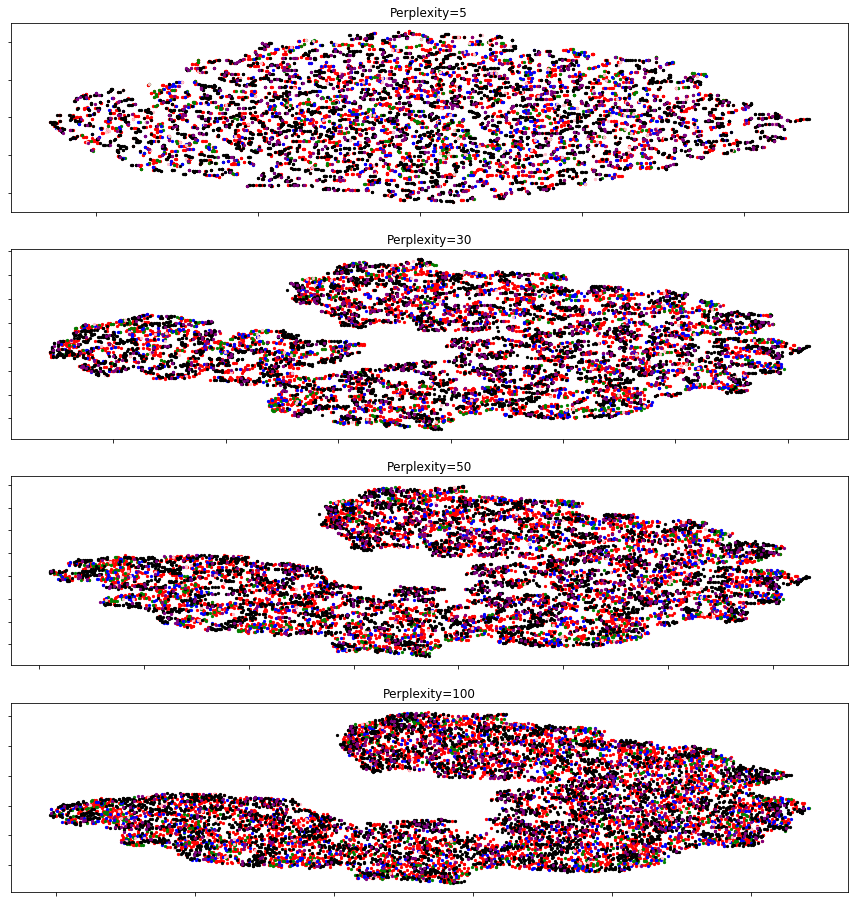

In [16]:
from matplotlib.ticker import NullFormatter
from sklearn import manifold

n_components = 2
(fig, subplots) = plt.subplots(4, figsize=(15, 16))
perplexities = [5, 30, 50, 100]
X = x
red = y == 1
green = y == 2
blue = y == 3
pink = y == 4
black = y == 5
purple = y == 6
s = 5

for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[red, 0], Y[red, 1], c="r", s=s)
    ax.scatter(Y[green, 0], Y[green, 1], c="g", s=s)
    ax.scatter(Y[blue, 0], Y[blue, 1], c="blue", s=s)
    ax.scatter(Y[pink, 0], Y[pink, 1], c="pink", s=s)
    ax.scatter(Y[black, 0], Y[black, 1], c="black", s=s)
    ax.scatter(Y[purple, 0], Y[purple, 1], c="purple", s=s)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

# 

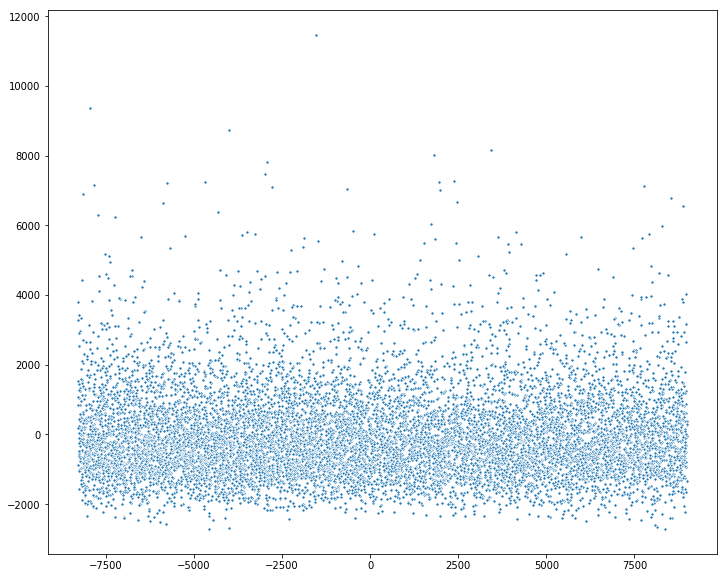

In [17]:
pca = PCA(n_components=2).fit(x)
reduced_data = PCA(n_components=2).fit_transform(x)
plt.figure(figsize=(12, 10))
sns.scatterplot(reduced_data[:,0], reduced_data[:,1], s=10)

In [18]:
print(pca.explained_variance_ratio_)

[0.92401674 0.06320456]


In [24]:
clasificadores = [
    SVC(gamma=2, C=1),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]
kf = KFold(7)
names = ['Maquina de vector de soporte gaussiana', 'Bosques aleatorios', 'AdaBoost', 'LDA', 'QDA']
for name, clf in zip(names, clasificadores):
    resultados = cross_val_score(clf, x, y, cv=kfold)
    print('Clasificador: {}\nExactitud media: {}, desviación estándar: {}'.format(name, 
                                                                                  resultados.mean(), resultados.std()))

Clasificador: Maquina de vector de soporte gaussiana
Exactitud media: 0.4197692879945006, desviación estándar: 0.010430863870376391
Clasificador: Bosques aleatorios
Exactitud media: 0.6654036518414584, desviación estándar: 0.02906028751673782
Clasificador: AdaBoost
Exactitud media: 0.6889793112540376, desviación estándar: 0.018454667811050113
Clasificador: LDA
Exactitud media: 0.6968375504976787, desviación estándar: 0.009589314938523545
Clasificador: QDA
Exactitud media: 0.6711292646407955, desviación estándar: 0.01265218014767447


In [20]:
clf = LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=200)
for confusion in datos.columns[1:]: 
    x_n = datos.drop(columns=[confusion], axis=1)
    resultados = cross_val_score(clf, x_n, y, cv=kfold)
    print("Resultado excluyendo la variable {}: {}, {}".format(confusion, resultados.mean(), resultados.std()))

Resultado excluyendo la variable ridagemn: 0.5956562108613561, 0.014392298220683532
Resultado excluyendo la variable ridreth1: 0.6932476716921079, 0.00848584514843638
Resultado excluyendo la variable indhhinc: 0.6947037940353884, 0.011285606225136103
Resultado excluyendo la variable indfminc: 0.6817022779279237, 0.012058409878672075
Resultado excluyendo la variable indfmpir: 0.6885914325803019, 0.015314518447216336
Resultado excluyendo la variable lbdvidms: 0.6923755803113198, 0.012482594521734782
Resultado excluyendo la variable lbxpt21: 0.6968372679931822, 0.006114055738751059
Resultado excluyendo la variable riagendr: 0.6939249291384554, 0.01292089845347613
Resultado excluyendo la variable dr1tkcal: 0.6953837823585359, 0.014155883310609603
Resultado excluyendo la variable dr1tcalc: 0.6944140385901142, 0.011798727178445559
Resultado excluyendo la variable dr1tphos: 0.6942196754965015, 0.012629632188859631
Resultado excluyendo la variable bmxwt: 0.6945089601009483, 0.01065069371444547

In [75]:
for var in datos.columns[1:]:    
    x_prueba = np.array(datos[var]).reshape(-1, 1)

    clf = LogisticRegression(multi_class='ovr', solver='liblinear')
    resultados = cross_val_score(clf, x_prueba, y, cv=kfold)
    print("Regresion con {}: {}, {}".format(var, resultados.mean(), resultados.std()))

Regresion con ridagemn: 0.6612320962775324, 0.023184769790101558
Regresion con ridreth1: 0.4623668226719276, 0.038274723341906375
Regresion con indhhinc: 0.4554730537794394, 0.01946336587161173
Regresion con indfminc: 0.4752640004520071, 0.014004739333552145
Regresion con indfmpir: 0.47283370843652595, 0.013403402832850112
Regresion con lbdvidms: 0.46129358808961046, 0.017018880208392387
Regresion con lbxpt21: 0.4161827050747225, 0.011885424886842405
Regresion con riagendr: 0.41977107718964535, 0.016914082260359314
Regresion con dr1tkcal: 0.43713446272353174, 0.015275330379802847
Regresion con dr1tcalc: 0.42966739803941884, 0.010369503700488721
Regresion con dr1tphos: 0.41977258388029337, 0.018992954924053757
Regresion con bmxwt: 0.48515909711562905, 0.012462415725258188
Regresion con bmxht: 0.4197695704989971, 0.020389191889052496
Regresion con bmxbmi: 0.5045597167421582, 0.005401382027315383
Regresion con bmxwaist: 0.5430761914627141, 0.009419127591605961
Regresion con dmdmartl: 0.78

In [77]:
clasificadores = [GradientBoostingClassifier(), BaggingClassifier()]

nombres =['Gradient Boost', 'Bagging']

for nombre, clf in zip(nombres, clasificadores):
    resultados = cross_val_score(clf, x, y, cv=kfold)
    print('Exactitud promedio en 10 folds para {}: {}, con sigma={}'.format(nombre, resultados.mean(), resultados.std()))

Exactitud promedio en 10 folds para Gradient Boost: 0.74582769109075, con sigma=0.00710267601474482
Exactitud promedio en 10 folds para Bagging: 0.725455255996158, con sigma=0.00653666688628158


In [80]:
clf1 = LogisticRegression(multi_class='ovr', solver='liblinear')
clf2 = GradientBoostingClassifier()
clf3 = BaggingClassifier()
clf4 = GaussianNB()
clf = VotingClassifier(estimators=[('lr', clf1), ('gb', clf2), ('b', clf3), ('nv', clf4)], voting='soft', 
                       weights=[1,2,2,1], flatten_transform=True)

resultados = cross_val_score(clf, x, y, cv=kfold)
print(resultados.mean(), resultados.std())

0.7364190671701525 0.014593702857952072


In [13]:
params = {'loss': ('deviance',), 'learning_rate': [0.1, 0.01],
          'n_estimators':[100, 150], 'criterion':['friedman_mse', 'mse'], 
          'subsample': [1.0, 0.99], 'min_samples_split' : [2, 3], 'min_samples_leaf': [1, 2]}
svc = GradientBoostingClassifier(verbose=1)
clf = GridSearchCV(svc, params,cv=5)

In [67]:
from keras.models import Sequential
model = Sequential()
model.add(Dense(16, input_dim=16, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x, np_utils.to_categorical(y - 1), epochs=5, batch_size=32)

Epoch 1/5
10308/10308 [==============================] - 2s 168us/step - loss: 10.1759 - accuracy: 0.3639
Epoch 2/5
10308/10308 [==============================] - 1s 121us/step - loss: 9.8149 - accuracy: 0.3859
Epoch 3/5
10308/10308 [==============================] - 1s 123us/step - loss: 9.0937 - accuracy: 0.4304
Epoch 4/5
10308/10308 [==============================] - 1s 126us/step - loss: 8.3624 - accuracy: 0.4717
Epoch 5/5
10308/10308 [==============================] - 1s 124us/step - loss: 7.5116 - accuracy: 0.5227


### Este modelo con esta inicialización me pareció prometedora, así que la seguí entrenando por otros cien epochs más, que no verán, pero si los siguientes 5 epochs para que vean la mejora.

In [73]:
model.fit(x, np_utils.to_categorical(y - 1), epochs=5, batch_size=32)

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Epoch 1/5
10308/10308 [==============================] - 2s 147us/step - loss: 0.8828 - accuracy: 0.7040
Epoch 2/5
10308/10308 [==============================] - 1s 124us/step - loss: 0.8971 - accuracy: 0.6984
Epoch 3/5
10308/10308 [==============================] - 1s 135us/step - loss: 0.8805 - accuracy: 0.7061
Epoch 4/5
10308/10308 [==============================] - 1s 125us/step - loss: 0.8809 - accuracy: 0.7015
Epoch 5/5
10308/10308 [==============================] - 1s 133us/step - loss: 0.8795 - accuracy: 0.7052
Saved model to disk


### Tan prometedor me pareció, que decidí entrenar el modelo en el Accarus, reduciendo el batch size y aumentando el número de epochs. En el código anterior pueden ver que guardé el modelo entrenado para cargarlo en el Accarus y seguirlo entrenando.

In [6]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(x, np_utils.to_categorical(y - 1), verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 90.37%


In [7]:
plot_model(loaded_model, to_file='model.png')

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.